In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
print("SciPy importado correctamente")

SciPy importado correctamente


In [3]:
# Crear dataset con missing values y outliers
np.random.seed(42)
n = 1000

datos = pd.DataFrame({
    'id': range(1, n+1),
    'edad': np.random.normal(35, 10, n).clip(18, 80),  # Normal con límites
    'salario': np.random.lognormal(10, 0.5, n),       # Distribución log-normal
    'horas_trabajo': np.random.normal(40, 5, n).clip(20, 60),
    'satisfaccion': np.random.randint(1, 6, n),
    'departamento': np.random.choice(['IT', 'Ventas', 'Marketing', 'HR'], n)
})

# Introducir missing values
mask_missing = np.random.random(n) < 0.1  # 10% missing
datos.loc[mask_missing, 'salario'] = np.nan

mask_missing_horas = np.random.random(n) < 0.05  # 5% missing
datos.loc[mask_missing_horas, 'horas_trabajo'] = np.nan

# Introducir outliers
outlier_indices = np.random.choice(n, 20, replace=False)
datos.loc[outlier_indices[:10], 'salario'] = datos.loc[outlier_indices[:10], 'salario'] * 10
datos.loc[outlier_indices[10:], 'horas_trabajo'] = np.random.choice([80, 90, 100], 10)

print(f"Dataset creado: {datos.shape}")
print("\nValores faltantes por columna:")
print(datos.isnull().sum())

Dataset creado: (1000, 6)

Valores faltantes por columna:
id                0
edad              0
salario          95
horas_trabajo    46
satisfaccion      0
departamento      0
dtype: int64


In [4]:
# Análisis detallado de missing values
print("Porcentaje de datos faltantes:")
print((datos.isnull().sum() / len(datos) * 100).round(2))

datos.info()

Porcentaje de datos faltantes:
id               0.0
edad             0.0
salario          9.5
horas_trabajo    4.6
satisfaccion     0.0
departamento     0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   int64  
 1   edad           1000 non-null   float64
 2   salario        905 non-null    float64
 3   horas_trabajo  954 non-null    float64
 4   satisfaccion   1000 non-null   int32  
 5   departamento   1000 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 43.1+ KB


In [5]:
# Patrón de missing values
!pip install missingno


   ---------------------------------------- 0/2 [seaborn]
   ---------------------------------------- 2/2 [missingno]



<Axes: >

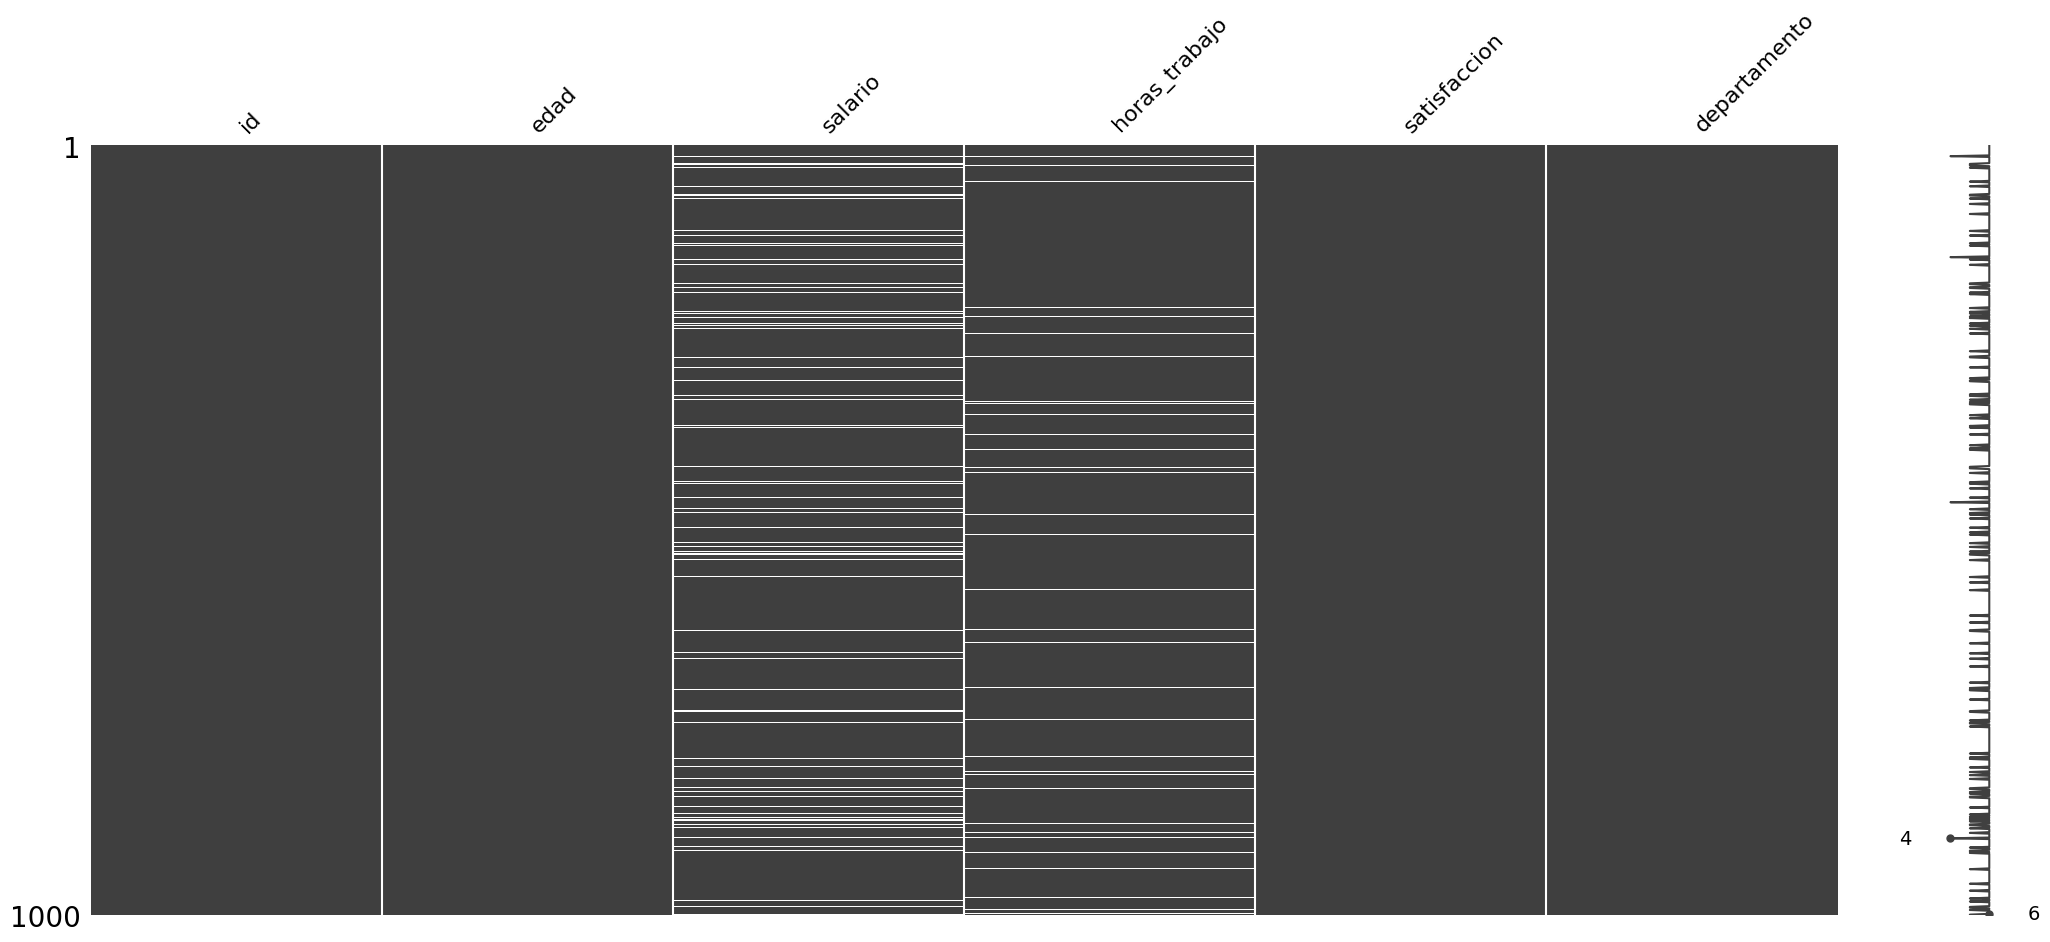

In [6]:
import missingno as msno
msno.matrix(datos)

In [7]:
# Análisis por departamento
print("Missing values por departamento:")
print(datos.groupby('departamento').apply(lambda x: x.isnull().sum()))

Missing values por departamento:
              id  edad  salario  horas_trabajo  satisfaccion  departamento
departamento                                                              
HR             0     0       20             13             0             0
IT             0     0       18              3             0             0
Marketing      0     0       23             17             0             0
Ventas         0     0       34             13             0             0


C:\Users\vylo0\AppData\Local\Temp\ipykernel_12920\1481061519.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(datos.groupby('departamento').apply(lambda x: x.isnull().sum()))


In [8]:
print(
    datos
    .groupby('departamento')[['salario', 'horas_trabajo']]
    .apply(lambda x: x.isnull().sum())
)

              salario  horas_trabajo
departamento                        
HR                 20             13
IT                 18              3
Marketing          23             17
Ventas             34             13


In [9]:
# Imputación por media para horas_trabajo
media_horas = datos['horas_trabajo'].mean()
datos['horas_trabajo'] = datos['horas_trabajo'].fillna(media_horas)

# Imputación por mediana para salario
mediana_salario = datos['salario'].median()
datos['salario'] = datos['salario'].fillna(mediana_salario)

# Verificación
print("Valores faltantes después de imputación:")
print(datos.isnull().sum())

Valores faltantes después de imputación:
id               0
edad             0
salario          0
horas_trabajo    0
satisfaccion     0
departamento     0
dtype: int64


In [10]:
# Función para detectar outliers usando IQR
def detectar_outliers_iqr(data, columna):
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return (data[columna] < limite_inferior) | (data[columna] > limite_superior)

In [11]:
# Detectar outliers en salario y horas
outliers_salario = detectar_outliers_iqr(datos, 'salario')
outliers_horas = detectar_outliers_iqr(datos, 'horas_trabajo')

print("Outliers detectados:")
print(f"Salario: {outliers_salario.sum()} ({outliers_salario.mean()*100:.1f}%)")
print(f"Horas trabajo: {outliers_horas.sum()} ({outliers_horas.mean()*100:.1f}%)")

Outliers detectados:
Salario: 55 (5.5%)
Horas trabajo: 24 (2.4%)


In [12]:
# Para horas_trabajo: cap at reasonable maximum
max_horas_normales = 60
datos.loc[datos['horas_trabajo'] > max_horas_normales, 'horas_trabajo'] = max_horas_normales

In [13]:
# Para salario: transformar usando log (más robusto)
datos['salario_log'] = np.log1p(datos['salario'])

In [14]:
# Comparar estadísticas antes y después
print("Estadísticas de salario original:")
print(datos['salario'].describe().round(2))

print("\nEstadísticas de salario transformado (log):")
print(datos['salario_log'].describe().round(2))

Estadísticas de salario original:
count      1000.00
mean      28034.05
std       31587.51
min        5063.46
25%       17302.19
50%       22873.10
75%       30819.42
max      518367.29
Name: salario, dtype: float64

Estadísticas de salario transformado (log):
count    1000.00
mean       10.06
std         0.53
min         8.53
25%         9.76
50%        10.04
75%        10.34
max        13.16
Name: salario_log, dtype: float64


In [15]:
# Verificar reducción de outliers
outliers_salario_log = detectar_outliers_iqr(datos, 'salario_log')
print(f"\nOutliers en salario log-transformado: {outliers_salario_log.sum()}")


Outliers en salario log-transformado: 29


In [16]:
datos_originales = datos.copy()

In [17]:
# Crear resumen de missing values
resumen_missing = pd.DataFrame({
    'missing_count': datos_originales.isnull().sum(),
    'missing_percent': (datos_originales.isnull().mean() * 100).round(2)
})

# Missing por departamento
missing_por_departamento = datos_originales.groupby('departamento').apply(
    lambda x: x.isnull().sum()
)

# Resumen de outliers
resumen_outliers = pd.DataFrame({
    'variable': ['salario', 'horas_trabajo', 'salario_log'],
    'outliers_detectados': [
        outliers_salario.sum(),
        outliers_horas.sum(),
        outliers_salario_log.sum()
    ],
    'porcentaje': [
        round(outliers_salario.mean() * 100, 2),
        round(outliers_horas.mean() * 100, 2),
        round(outliers_salario_log.mean() * 100, 2)
    ]
})

# Guardar Excel
with pd.ExcelWriter("ejercicio_dia5_missing_outliers.xlsx", engine="openpyxl") as writer:
    datos_originales.to_excel(writer, sheet_name="datos_originales", index=False)
    resumen_missing.reset_index().to_excel(writer, sheet_name="resumen_missing", index=False)
    missing_por_departamento.reset_index().to_excel(writer, sheet_name="missing_por_departamento", index=False)
    datos.to_excel(writer, sheet_name="datos_finales", index=False)
    resumen_outliers.to_excel(writer, sheet_name="resumen_outliers", index=False)

print("Archivo Excel del Día 5 creado correctamente")

C:\Users\vylo0\AppData\Local\Temp\ipykernel_12920\1397051323.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_por_departamento = datos_originales.groupby('departamento').apply(


ValueError: cannot insert departamento, already exists

In [18]:
missing_por_departamento = (
    datos_originales
    .groupby('departamento')
    .agg(lambda x: x.isnull().sum())
    .reset_index()
)

In [19]:
with pd.ExcelWriter("ejercicio_dia5_missing_outliers.xlsx", engine="openpyxl") as writer:
    datos_originales.to_excel(writer, sheet_name="datos_originales", index=False)
    resumen_missing.reset_index().to_excel(writer, sheet_name="resumen_missing", index=False)
    missing_por_departamento.to_excel(writer, sheet_name="missing_por_departamento", index=False)
    datos.to_excel(writer, sheet_name="datos_finales", index=False)
    resumen_outliers.to_excel(writer, sheet_name="resumen_outliers", index=False)

print("Archivo Excel del Día 5 creado correctamente")

Archivo Excel del Día 5 creado correctamente


In [20]:
import matplotlib.pyplot as plt

C:\Users\vylo0\AppData\Local\Temp\ipykernel_12920\461066668.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


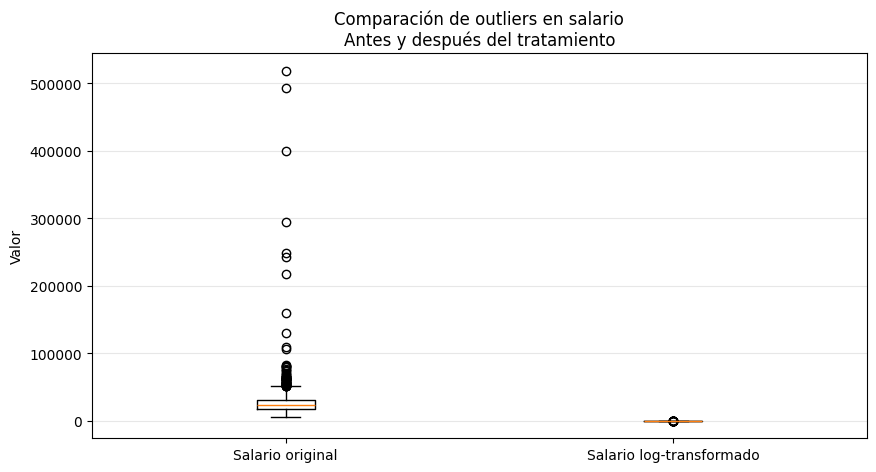

In [21]:
plt.figure(figsize=(10, 5))

plt.boxplot(
    [datos['salario'], datos['salario_log']],
    labels=['Salario original', 'Salario log-transformado'],
    showfliers=True
)

plt.title('Comparación de outliers en salario\nAntes y después del tratamiento')
plt.ylabel('Valor')
plt.grid(axis='y', alpha=0.3)

plt.show()

In [22]:
plt.boxplot(
    [salario_original, salario_log],
    tick_labels=['Salario', 'Salario (log)']
)

NameError: name 'salario_original' is not defined

C:\Users\vylo0\AppData\Local\Temp\ipykernel_12920\1882584313.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


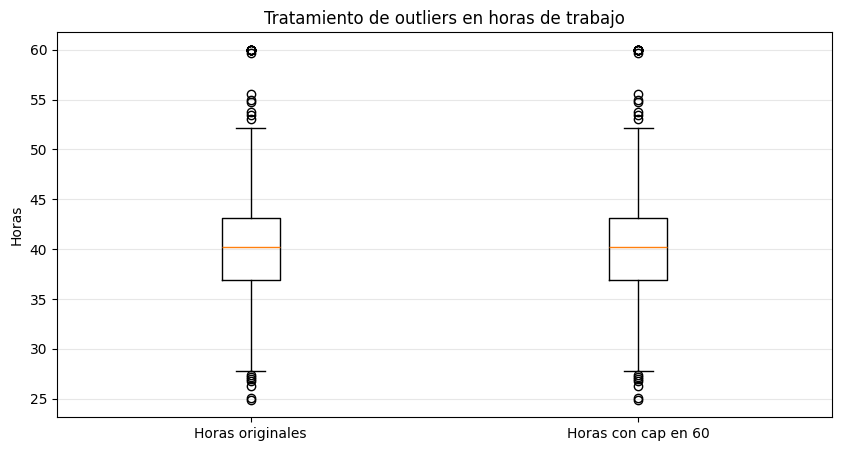

In [23]:
plt.figure(figsize=(10, 5))

plt.boxplot(
    [datos_originales['horas_trabajo'], datos['horas_trabajo']],
    labels=['Horas originales', 'Horas con cap en 60'],
    showfliers=True
)

plt.title('Tratamiento de outliers en horas de trabajo')
plt.ylabel('Horas')
plt.grid(axis='y', alpha=0.3)

plt.show()

In [24]:
plt.figure(figsize=(10, 5))
plt.boxplot(
    [datos['salario'], datos['salario_log']],
    labels=['Salario original', 'Salario log-transformado'],
    showfliers=True
)
plt.title('Outliers en salario: antes y después')
plt.ylabel('Valor')
plt.grid(axis='y', alpha=0.3)

plt.savefig("boxplot_salario_outliers_dia5.png", dpi=300, bbox_inches='tight')
plt.close()

C:\Users\vylo0\AppData\Local\Temp\ipykernel_12920\3518137860.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(
